In [54]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats
import math
from pandas_profiling import ProfileReport

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
import sklearn


In [12]:
df_raw=pd.read_csv('/Users/jkc/Data/house-prices-advanced-regression-techniques/train.csv')

df_test_raw=pd.read_csv('/Users/jkc/Data/house-prices-advanced-regression-techniques/test.csv')

In [13]:
def prepDataset(df):
    df=df.astype({'MSSubClass': 'category'})
    df=df.drop(axis=1,labels="Id")
    df['LotFrontage_na']=df['LotFrontage'].isna().astype("int")
    df.LotFrontage=df.LotFrontage.fillna(0)
    df.MasVnrArea=df.MasVnrArea.fillna(0)
    df.GarageYrBlt[df.GarageYrBlt.isna()]=df.YearRemodAdd[df.GarageYrBlt.isna()]
    df_explode=pd.get_dummies(df,dummy_na=True)
    return df_explode

def removeOutliers(df, y_col, min_cutoff, max_cutoff, scale="log"):
    if scale=="log":
        df = df[np.log(df[y_col])<max_cutoff]
        df = df[np.log(df[y_col])>min_cutoff]
    else:
        df = df[df[y_col]<max_cutoff]
        df = df[df[y_col]>min_cutoff]
    df = df.reset_index(drop=True)
    return df
    
def transformY(y):
    return np.log(y)

def transformYPred(y_pred):
    return np.exp(y_pred)


In [119]:
def matchTestTrain(X_train, df_test):
    X_test = X_train.iloc[0:0].append(df_test)[X_train.columns]
    X_test.fillna(0, inplace=True)
    return X_test

def fillInfZeroVals(y_pred):
    masked_y_pred = np.ma.array(y_pred, mask=~np.isfinite(y_pred))
    max_val = np.ma.max(masked_y_pred, fill_value=-np.inf)

    masked_y_pred = np.ma.array(y_pred, mask=(y_pred==0))
    min_val = np.ma.min(masked_y_pred, fill_value=np.inf)
    y_pred[y_pred==0]=min_val
    y_pred[y_pred==np.inf]=max_val
    return y_pred

def output_result(id_vals, y_pred, result_label='2'):
    result = pd.DataFrame({'Id': id_vals, "SalePrice":y_pred})
    result.to_csv("/Users/jkc/Data/house-prices-advanced-regression-techniques/result"+result_label+".csv",index=False)

In [31]:
#Data prep
df_train = removeOutliers(df_raw,'SalePrice', 10.7, 13.5)
df_train = prepDataset(df_train)
y = df_train.SalePrice
y_log = np.log(df_train.SalePrice)
X = df_train.drop('SalePrice', axis=1)

scaler = StandardScaler()
#scaler.fit(X)

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)



/Users/jkc/workspace/venv/vdata/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


5

## Linear Regression

In [41]:
regr = LinearRegression()
lregr = Lasso(random_state=0)
rregr = Ridge(random_state=0)
eregr = ElasticNet(random_state=0)


lregrCV = LassoCV(random_state=0)
rregrCV = RidgeCV()
eregrCV = ElasticNetCV(random_state=0)


alpha_range=[.00001, .001, .003, .004, .005, .01, .05, .1, 1, 10, 100]
lasso_params = {"alpha": alpha_range}
ridge_params = {"alpha": alpha_range}
elasticnet_params = {"alpha":alpha_range}




In [39]:
#Linear Regression
randm = RandomizedSearchCV(estimator=regr,
                           param_distributions = {},
                           cv = kf,
                           n_jobs=-1)
randm.fit(X, y)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)
print("\n The best score across ALL searched params:\n",
      randm.best_score_)
print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)
print("\n ========================================================")
#grid_search = GridSearchCV(model, param_grid, scoring="mean_squared_error", n_jobs=-1, cv=kf)
#grid_result = grid_search.fit(X, y)



 Results from Random Search 

 The best estimator across ALL searched params:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

 The best score across ALL searched params:
 0.7745747478225636

 The best parameters across ALL searched params:
 {}



/Users/jkc/workspace/venv/vdata/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [55]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [56]:
#Linear Regression
pipe = Pipeline(steps=[('sscaler', scaler), ('lasso', lregr)])



# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
'lasso__alpha': alpha_range,
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=kf, scoring="neg_mean_squared_error")


randm = RandomizedSearchCV(pipe, param_grid,
                           cv = kf,
                           n_jobs=-1)
search.fit(X, y_log)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",search.best_estimator_)
print("\n The best score across ALL searched params:\n",search.best_score_)
print("\n The best parameters across ALL searched params:\n",search.best_params_)
print("\n ========================================================")
#grid_search = GridSearchCV(model, param_grid, scoring="mean_squared_error", n_jobs=-1, cv=kf)
#grid_result = grid_search.fit(X, y)



 Results from Random Search 

 The best estimator across ALL searched params:
 Pipeline(memory=None,
         steps=[('sscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=0, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

 The best score across ALL searched params:
 -0.019817046134293186

 The best parameters across ALL searched params:
 {'lasso__alpha': 0.005}



In [95]:
search.cv_results_
lregr.set_params(**{'alpha':0.05})
lregr.fit(X,y_log)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
pd.options.display.width=0
pd.options.display.max_rows=400

In [114]:
lasso_coeff = pd.DataFrame(zip(lregr.coef_,X.columns))
lasso_coeff[0]=abs(lasso_coeff[0])
lasso_coeff.sort_values([0],ascending=False).reset_index(drop=True)

0                      1
0    2.654503e-02            OverallQual
1    3.264621e-03           YearRemodAdd
2    3.139466e-03              YearBuilt
3    6.976311e-04            GarageYrBlt
4    5.632360e-04               PoolArea
5    5.257659e-04            ScreenPorch
6    2.826938e-04             GarageArea
7    2.528244e-04              3SsnPorch
8    2.148789e-04          EnclosedPorch
9    1.956598e-04             WoodDeckSF
10   1.516235e-04               2ndFlrSF
11   1.496760e-04               1stFlrSF
12   1.402376e-04            OpenPorchSF
13   1.327221e-04              GrLivArea
14   1.004365e-04            TotalBsmtSF
15   5.516684e-05             BsmtFinSF1
16   4.997522e-05            LotFrontage
17   3.250258e-05             MasVnrArea
18   2.807846e-05             BsmtFinSF2
19   1.669521e-05           LowQualFinSF
20   3.740038e-06                MiscVal
21   2.317243e-06                LotArea
22   1.475638e-10              BsmtUnfSF
23   0.000000e+00       BsmtFinType2_BLQ
24   0.000000e+00       BsmtFinType2_ALQ
25   0.000000e+00       BsmtFinType1_nan
26   0.000000e+00       BsmtFinType1_Unf
27   0.000000e+00       BsmtFinType1_Rec
28   0.000000e+00       BsmtFinType1_LwQ
29   0.000000e+00       BsmtFinType1_GLQ
30   0.000000e+00       BsmtFinType1_BLQ
31   0.000000e+00          HeatingQC_nan
32   0.000000e+00       BsmtFinType1_ALQ
33   0.000000e+00       BsmtExposure_nan
34   0.000000e+00       BsmtFinType2_LwQ
35   0.000000e+00        BsmtExposure_No
36   0.000000e+00        BsmtExposure_Mn
37   0.000000e+00        BsmtExposure_Gd
38   0.000000e+00        BsmtExposure_Av
39   0.000000e+00           BsmtCond_nan
40   0.000000e+00            BsmtCond_TA
41   0.000000e+00       BsmtFinType2_GLQ
42   0.000000e+00          Heating_Floor
43   0.000000e+00       BsmtFinType2_Rec
44   0.000000e+00            BsmtCond_Gd
45   0.000000e+00           HeatingQC_Po
46   0.000000e+00           HeatingQC_Gd
47   0.000000e+00           HeatingQC_Fa
48   0.000000e+00           HeatingQC_Ex
49   0.000000e+00           CentralAir_N
50   0.000000e+00           CentralAir_Y
51   0.000000e+00         CentralAir_nan
52   0.000000e+00            Heating_nan
53   0.000000e+00       BsmtFinType2_Unf
54   0.000000e+00           Heating_Wall
55   0.000000e+00           Heating_OthW
56   0.000000e+00           Heating_Grav
57   0.000000e+00           Heating_GasW
58   0.000000e+00           Heating_GasA
59   0.000000e+00           HeatingQC_TA
60   0.000000e+00       BsmtFinType2_nan
61   0.000000e+00            BsmtCond_Po
62   0.000000e+00       Foundation_PConc
63   0.000000e+00            BsmtCond_Fa
64   0.000000e+00        Exterior2nd_nan
65   0.000000e+00           ExterQual_Fa
66   0.000000e+00           ExterQual_Ex
67   0.000000e+00         MasVnrType_nan
68   0.000000e+00       MasVnrType_Stone
69   0.000000e+00        MasVnrType_None
70   0.000000e+00     MasVnrType_BrkFace
71   0.000000e+00      MasVnrType_BrkCmn
72   0.000000e+00    Exterior2nd_Wd Shng
73   0.000000e+00           ExterQual_TA
74   0.000000e+00    Exterior2nd_Wd Sdng
75   0.000000e+00    Exterior2nd_VinylSd
76   0.000000e+00     Exterior2nd_Stucco
77   0.000000e+00      Exterior2nd_Stone
78   0.000000e+00    Exterior2nd_Plywood
79   0.000000e+00      Exterior2nd_Other
80   0.000000e+00    Exterior2nd_MetalSd
81   0.000000e+00           ExterQual_Gd
82   0.000000e+00          ExterQual_nan
83   0.000000e+00           BsmtQual_nan
84   0.000000e+00        Foundation_Slab
85   0.000000e+00            BsmtQual_TA
86   0.000000e+00            BsmtQual_Gd
87   0.000000e+00            BsmtQual_Fa
88   0.000000e+00            BsmtQual_Ex
89   0.000000e+00         Foundation_nan
90   0.000000e+00        Foundation_Wood
91   0.000000e+00       Foundation_Stone
92   0.000000e+00       Electrical_FuseF
93   0.000000e+00           ExterCond_Ex
94   0.000000e+00      Foundation_CBlock
95   0.000000e+00      Foundation_BrkTil
96   0.000000e+00          ExterCond_na

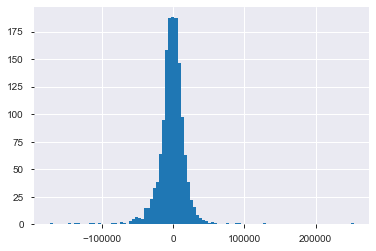

In [89]:
diffs = pd.Series(transformYPred(search.predict(X))-y)
plt.hist(diffs,100)
df_off=df_train[(diffs>70000)|(diffs<-70000)]


In [85]:
df_ok=df_train[(diffs<70000)&(diffs>-70000)].describe()


In [90]:
(df_ok-df_off)/df_ok
df_off.to_csv("/Users/jkc/Data/df_off.csv")

In [ ]:
for i, (train_index, validate_index) in enumerate(kf.split(X)):
    X_train, X_validate = X.loc[train_index,:], X.loc[validate_index,:]
    y_train, y_validate = y[train_index], y[validate_index]
    scaler.fit(X_train)
    scaler.transform(X_validate)
    if "params" in current_model_dict.keys():
        for param in current_model_dict["params"].keys():
            for param_val in current_model_dict["params"][param]:
                param_dict = {param: param_val}
                print(param_dict)
                model.set_params(**param_dict)
                model.fit(X_train, y_train)
                y_pred = model.predict(scaler.transform(X_validate))
                try:
                    output = np.sqrt(metrics.mean_squared_error(y_validate,np.exp(y_pred)))
                except ValueError:
                    pass
                results.append([model_type, i, param_val, output])
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(scaler.transform(X_validate))
        try:
            output = np.sqrt(metrics.mean_squared_error(y_validate,np.exp(y_pred)))
        except ValueError:
            pass
        results.append([model_type, i, None, output])


## Tree-based Models

In [ ]:
ranregr = RandomForestRegressor(random_state=0)
model = XGBClassifier()

rf_params = {"max_depth": [2,4,5,10,20]}

In [239]:
results

[['linear', 0, None, 195165.44826529388],
 ['linear', 1, None, 195165.44826529388],
 ['linear', 2, None, 195165.44826529388],
 ['linear', 3, None, 195165.44826529388],
 ['linear', 4, None, 195165.44826529388],
 ['lasso', 0, 1e-05, 195165.44826529388],
 ['lasso', 0, 0.001, 195165.44826529388],
 ['lasso', 0, 0.01, 195165.44826529388],
 ['lasso', 0, 0.1, 195165.44826529388],
 ['lasso', 0, 1, 195165.44826529388],
 ['lasso', 0, 10, 195165.44826529388],
 ['lasso', 0, 100, 195165.44826529388],
 ['lasso', 1, 1e-05, 195165.44826529388],
 ['lasso', 1, 0.001, 195165.44826529388],
 ['lasso', 1, 0.01, 195165.44826529388],
 ['lasso', 1, 0.1, 195165.44826529388],
 ['lasso', 1, 1, 195165.44826529388],
 ['lasso', 1, 10, 200598.33966185458],
 ['lasso', 1, 100, 200598.33966185458],
 ['lasso', 2, 1e-05, 200598.33966185458],
 ['lasso', 2, 0.001, 200598.33966185458],
 ['lasso', 2, 0.01, 200598.33966185458],
 ['lasso', 2, 0.1, 200598.33966185458],
 ['lasso', 2, 1, 200598.33966185458],
 ['lasso', 2, 10, 20059

In [238]:
for alpha in alpha_range:
    print(alpha)
    for train_index, validate_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        
        lasso = LinearRegression()
        lasso.fit(scaler.transform(X_train), np.log(y_train))
        y_pred=regr.predict(scaler.transform(X_test))
        print(np.sqrt(metrics.mean_squared_error(y_test,np.exp(y_pred))))
        for param in current_model_dict["params"].keys():
            for param_val in current_model_dictent_model_dict["params"][param]:
                param_dict = {param: param_val}
            model.set_params(param_dict)
for alpha in alpha_range:
    print(alpha)
    for train_index, validate_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_validate = X.loc[train_index,:], X.loc[validate_index,:]
        y_train, y_validate = y[train_index], y[validate_index]
        scaler.fit(X_train)
        scaler.transform(X_validate)
        lasso = LinearRegression()
        lasso.fit(scaler.transform(X_train), np.log(y_train))
        y_pred=regr.predict(scaler.transform(X_test))
        print(np.sqrt(metrics.mean_squared_error(y_test,np.exp(y_pred))))

1e-05


NameError: name 'y_test' is not defined

In [125]:
y_test

array([123143.35146464, 152729.48624673, 176265.94107674, ...,
       164177.3473925 , 120034.97319844, 226681.73250886])

In [123]:
df_test = prepDataset(df_test_raw)
X_test=matchTestTrain(X_train,df_test)

y_test_log=search.predict(X_test)
y_test = transformYPred(y_test_log)
output_result(df_test_raw.Id,y_test,result_label='7')


/Users/jkc/workspace/venv/vdata/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jkc/workspace/venv/vdata/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [162]:
print(df_test.info())
print(df_train.info())
output = pd.concat([df_train, df_test])[df_train.columns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 330 entries, LotFrontage to SaleCondition_nan
dtypes: float64(11), int64(25), uint8(294)
memory usage: 829.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Columns: 348 entries, LotFrontage to SaleCondition_nan
dtypes: float64(3), int64(34), uint8(311)
memory usage: 861.4 KB
None


In [137]:
output2 = df_train.append(df_test)

In [159]:
pd.DataFrame({'var':output.columns,'count':(output == output2).sum()}).sort_values(['count'], axis=0)
#output.columns==output2.columns
output[['Heating_Floor']]==output2[['Heating_Floor']]

Heating_Floor
0              True
1              True
2              True
3              True
4              True
5              True
6              True
7              True
8              True
9              True
10             True
11             True
12             True
13             True
14             True
15             True
16             True
17             True
18             True
19             True
20             True
21             True
22             True
23             True
24             True
25             True
26             True
27             True
28             True
29             True
30             True
31             True
32             True
33             True
34             True
35             True
36             True
37             True
38             True
39             True
40             True
41             True
42             True
43             True
44             True
45             True
46             True
47             True
48             True
49             True
50             True
51             True
52             True
53             True
54             True
55             True
56             True
57             True
58             True
59             True
60             True
61             True
62             True
63             True
64             True
65             True
66             True
67             True
68             True
69             True
70             True
71             True
72             True
73             True
74             True
75             True
76             True
77             True
78             True
79             True
80             True
81             True
82             True
83             True
84             True
85             True
86             True
87             True
88             True
89             True
90             True
91             True
92             True
93             True
94             True
95             True
96             True
97             True
98             True
99             True
100            True
101            True
102            True
103            True
104            True
105            True
106            True
107            True
108            True
109            True
110            True
111            True
112            True
113            True
114            True
115            True
116            True
117            True
118            True
119            True
120            True
121            True
122            True
123            True
124            True
125            True
126            True
127            True
128            True
129            True
130            True
131            True
132            True
133            True
134            True
135            True
136            True
137            True
138            True
139            True
140            True
141            True
142            True
143            True
144            True
145            True
146            True
147            True
148            True
149            True
150            True
151            True
152            True
153            True
154            True
155            True
156            True
157            True
158            True
159            True
160            True
161            True
162            True
163            True
164            True
165            True
166            True
167            True
168            True
169            True
170            True
171            True
172            True
173            True
174            True
175            True
176            True
177            True
178            True
179            True
180            True
181            True
182            True
183            True
184            True
185            True
186            True
187            True
188            True
189            True
190            True
191            True
192            True
193            True
194            True
195            True
196            True
197            True
198            True
199   

In [164]:
df_train.iloc[0:0]

Empty DataFrame
Columns: [LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SalePrice, LotFrontage_na, MSSubClass_20.0, MSSubClass_30.0, MSSubClass_40.0, MSSubClass_45.0, MSSubClass_50.0, MSSubClass_60.0, MSSubClass_70.0, MSSubClass_75.0, MSSubClass_80.0, MSSubClass_85.0, MSSubClass_90.0, MSSubClass_120.0, MSSubClass_160.0, MSSubClass_180.0, MSSubClass_190.0, MSSubClass_nan, MSZoning_C (all), MSZoning_FV, MSZoning_RH, MSZoning_RL, MSZoning_RM, MSZoning_nan, Street_Grvl, Street_Pave, Street_nan, Alley_Grvl, Alley_Pave, Alley_nan, LotShape_IR1, LotShape_IR2, LotShape_IR3, LotShape_Reg, LotShape_nan, LandContour_Bnk, LandContour_HLS, LandContour_Low, LandContour_Lvl, LandContour_nan, Utilities_AllPub, Utilities_NoSeWa, Utilities_nan, LotConfig_Corner, LotConfig_CulDSac, LotConfig_FR2, LotConfig_FR3, LotConfig_Inside, LotConfig_nan, LandSlope_Gtl, LandSlope_Mod, LandSlope_Sev, LandSlope_nan, Neighborhood_Blmngtn, Neighborhood_Blueste, Neighborhood_BrDale, Neighborhood_BrkSide, Neighborhood_ClearCr, Neighborhood_CollgCr, Neighborhood_Crawfor, Neighborhood_Edwards, Neighborhood_Gilbert, Neighborhood_IDOTRR, Neighborhood_MeadowV, Neighborhood_Mitchel, ...]
Index: []

[0 rows x 348 columns]

In [160]:
np.nan==np.nan

False

In [134]:
output.info()
set(output.columns) - set(df_train.columns)
set(df_train.columns) - set(df_test.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912 entries, 0 to 1458
Columns: 349 entries, 1stFlrSF to YrSold
dtypes: float64(31), int64(25), uint8(293)
memory usage: 2.1 MB


{'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'GarageQual_Ex',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'MiscFeature_TenC',
 'PoolQC_Fa',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'SalePrice',
 'Utilities_NoSeWa'}

In [191]:
sorted(y_pred, reverse=True)

[1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 677234.4414299176,
 610565.7651153045,
 598048.4245174739,
 563262.1882741599,
 548937.2250480709,
 544238.8142706486,
 538319.0479310321,
 523417.30546643294,
 518062.3402307102,
 517159.2405023644,
 514572.72343701206,
 508531.21006928943,
 494756.8808279817,
 466918.6736042933,
 453118.8301975641,
 449911.74580275925,
 449706.697428384,
 442621.4995670633,
 438663.17647806095,
 435690.1019472813,
 435348.27429394674,
 434362.7151729362,
 431268.43479813554,
 418955.5233552413,
 414028.1464239181,
 412959.2929472657,
 411589.2745416148,
 409718.8517825779,
 407845.2602432249,
 403514.4941206291,
 401270.3223068538,
 400773.90941935446,
 399794.5539085867,
 396061.690226055,
 393730.34115377243,
 393608.1379596818,
 393495.54187587864,
 392581.1431064646,
 387304.82397784095,
 387056.138

In [162]:
print(df_test.info())
print(df_train.info())
output = pd.concat([df_train, df_test])[df_train.columns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 330 entries, LotFrontage to SaleCondition_nan
dtypes: float64(11), int64(25), uint8(294)
memory usage: 829.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Columns: 348 entries, LotFrontage to SaleCondition_nan
dtypes: float64(3), int64(34), uint8(311)
memory usage: 861.4 KB
None


In [137]:
output2 = df_train.append(df_test)

In [159]:
pd.DataFrame({'var':output.columns,'count':(output == output2).sum()}).sort_values(['count'], axis=0)
#output.columns==output2.columns
output[['Heating_Floor']]==output2[['Heating_Floor']]

Heating_Floor
0              True
1              True
2              True
3              True
4              True
5              True
6              True
7              True
8              True
9              True
10             True
11             True
12             True
13             True
14             True
15             True
16             True
17             True
18             True
19             True
20             True
21             True
22             True
23             True
24             True
25             True
26             True
27             True
28             True
29             True
30             True
31             True
32             True
33             True
34             True
35             True
36             True
37             True
38             True
39             True
40             True
41             True
42             True
43             True
44             True
45             True
46             True
47             True
48             True
49             True
50             True
51             True
52             True
53             True
54             True
55             True
56             True
57             True
58             True
59             True
60             True
61             True
62             True
63             True
64             True
65             True
66             True
67             True
68             True
69             True
70             True
71             True
72             True
73             True
74             True
75             True
76             True
77             True
78             True
79             True
80             True
81             True
82             True
83             True
84             True
85             True
86             True
87             True
88             True
89             True
90             True
91             True
92             True
93             True
94             True
95             True
96             True
97             True
98             True
99             True
100            True
101            True
102            True
103            True
104            True
105            True
106            True
107            True
108            True
109            True
110            True
111            True
112            True
113            True
114            True
115            True
116            True
117            True
118            True
119            True
120            True
121            True
122            True
123            True
124            True
125            True
126            True
127            True
128            True
129            True
130            True
131            True
132            True
133            True
134            True
135            True
136            True
137            True
138            True
139            True
140            True
141            True
142            True
143            True
144            True
145            True
146            True
147            True
148            True
149            True
150            True
151            True
152            True
153            True
154            True
155            True
156            True
157            True
158            True
159            True
160            True
161            True
162            True
163            True
164            True
165            True
166            True
167            True
168            True
169            True
170            True
171            True
172            True
173            True
174            True
175            True
176            True
177            True
178            True
179            True
180            True
181            True
182            True
183            True
184            True
185            True
186            True
187            True
188            True
189            True
190            True
191            True
192            True
193            True
194            True
195            True
196            True
197            True
198            True
199   

In [164]:
df_train.iloc[0:0]

Empty DataFrame
Columns: [LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SalePrice, LotFrontage_na, MSSubClass_20.0, MSSubClass_30.0, MSSubClass_40.0, MSSubClass_45.0, MSSubClass_50.0, MSSubClass_60.0, MSSubClass_70.0, MSSubClass_75.0, MSSubClass_80.0, MSSubClass_85.0, MSSubClass_90.0, MSSubClass_120.0, MSSubClass_160.0, MSSubClass_180.0, MSSubClass_190.0, MSSubClass_nan, MSZoning_C (all), MSZoning_FV, MSZoning_RH, MSZoning_RL, MSZoning_RM, MSZoning_nan, Street_Grvl, Street_Pave, Street_nan, Alley_Grvl, Alley_Pave, Alley_nan, LotShape_IR1, LotShape_IR2, LotShape_IR3, LotShape_Reg, LotShape_nan, LandContour_Bnk, LandContour_HLS, LandContour_Low, LandContour_Lvl, LandContour_nan, Utilities_AllPub, Utilities_NoSeWa, Utilities_nan, LotConfig_Corner, LotConfig_CulDSac, LotConfig_FR2, LotConfig_FR3, LotConfig_Inside, LotConfig_nan, LandSlope_Gtl, LandSlope_Mod, LandSlope_Sev, LandSlope_nan, Neighborhood_Blmngtn, Neighborhood_Blueste, Neighborhood_BrDale, Neighborhood_BrkSide, Neighborhood_ClearCr, Neighborhood_CollgCr, Neighborhood_Crawfor, Neighborhood_Edwards, Neighborhood_Gilbert, Neighborhood_IDOTRR, Neighborhood_MeadowV, Neighborhood_Mitchel, ...]
Index: []

[0 rows x 348 columns]

In [160]:
np.nan==np.nan

False

In [134]:
output.info()
set(output.columns) - set(df_train.columns)
set(df_train.columns) - set(df_test.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912 entries, 0 to 1458
Columns: 349 entries, 1stFlrSF to YrSold
dtypes: float64(31), int64(25), uint8(293)
memory usage: 2.1 MB


{'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'GarageQual_Ex',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'MiscFeature_TenC',
 'PoolQC_Fa',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'SalePrice',
 'Utilities_NoSeWa'}

In [191]:
sorted(y_pred, reverse=True)

[1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 1232125.864529862,
 677234.4414299176,
 610565.7651153045,
 598048.4245174739,
 563262.1882741599,
 548937.2250480709,
 544238.8142706486,
 538319.0479310321,
 523417.30546643294,
 518062.3402307102,
 517159.2405023644,
 514572.72343701206,
 508531.21006928943,
 494756.8808279817,
 466918.6736042933,
 453118.8301975641,
 449911.74580275925,
 449706.697428384,
 442621.4995670633,
 438663.17647806095,
 435690.1019472813,
 435348.27429394674,
 434362.7151729362,
 431268.43479813554,
 418955.5233552413,
 414028.1464239181,
 412959.2929472657,
 411589.2745416148,
 409718.8517825779,
 407845.2602432249,
 403514.4941206291,
 401270.3223068538,
 400773.90941935446,
 399794.5539085867,
 396061.690226055,
 393730.34115377243,
 393608.1379596818,
 393495.54187587864,
 392581.1431064646,
 387304.82397784095,
 387056.138

In [110]:
df_test

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
5     1466          60       RL         75.0    10000   Pave   NaN      IR1   
6     1467          20       RL          NaN     7980   Pave   NaN      IR1   
7     1468          60       RL         63.0     8402   Pave   NaN      IR1   
8     1469          20       RL         85.0    10176   Pave   NaN      Reg   
9     1470          20       RL         70.0     8400   Pave   NaN      Reg   
10    1471         120       RH         26.0     5858   Pave   NaN      IR1   
11    1472         160       RM         21.0     1680   Pave   NaN      Reg   
12    1473         160       RM         21.0     1680   Pave   NaN      Reg   
13    1474         160       RL         24.0     2280   Pave   NaN      Reg   
14    1475         120       RL         24.0     2280   Pave   NaN      Reg   
15    1476          60       RL        102.0    12858   Pave   NaN      IR1   
16    1477          20       RL         94.0    12883   Pave   NaN      IR1   
17    1478          20       RL         90.0    11520   Pave   NaN      Reg   
18    1479          20       RL         79.0    14122   Pave   NaN      IR1   
19    1480          20       RL        110.0    14300   Pave   NaN      Reg   
20    1481          60       RL        105.0    13650   Pave   NaN      Reg   
21    1482         120       RL         41.0     7132   Pave   NaN      IR1   
22    1483          20       RL        100.0    18494   Pave   NaN      IR1   
23    1484         120       RL         43.0     3203   Pave   NaN      Reg   
24    1485          80       RL         67.0    13300   Pave   NaN      IR1   
25    1486          60       RL         63.0     8577   Pave   NaN      IR1   
26    1487          60       RL         60.0    17433   Pave   NaN      IR2   
27    1488          20       RL         73.0     8987   Pave   NaN      Reg   
28    1489          20       FV         92.0     9215   Pave   NaN      Reg   
29    1490          20       FV         84.0    10440   Pave   NaN      Reg   
30    1491          60       RL         70.0    11920   Pave   NaN      Reg   
31    1492          30       RH         70.0     9800   Pave   NaN      Reg   
32    1493          20       RL         39.0    15410   Pave   NaN      IR1   
33    1494          60       RL         85.0    13143   Pave   NaN      IR1   
34    1495          60       RL         88.0    11134   Pave   NaN      Reg   
35    1496         120       FV         25.0     4835   Pave   NaN      IR1   
36    1497         160       FV         39.0     3515   Pave  Pave      Reg   
37    1498         160       FV         30.0     3215   Pave  Pave      Reg   
38    1499         160       FV         24.0     2544   Pave  Pave      Reg   
39    1500         160       FV         24.0     2544   Pave  Pave      Reg   
40    1501         160       FV          NaN     2980   Pave   NaN      Reg   
41    1502         160       FV          NaN     2403   Pave   NaN      IR1   
42    1503          20       FV         57.0    12853   Pave  Pave      IR1   
43    1504          60       FV         68.0     7379   Pave   NaN      IR1   
44    1505          20       FV         80.0     8000   Pave   NaN      Reg   
45    1506          20       RL          NaN    10456   Pave   NaN      IR1   
46    1507          60       RL         80.0    10791   Pave   NaN      Reg   
47    1508          50       RL          NaN    18837   Pave   NaN      IR1   
48    1509          60       RL         80.0     9600   Pave   NaN      Reg   
49    1510          20       RL         80.0     9600   Pa

In [78]:
#EDA
#profile = ProfileReport(df_train, title='Pandas Profiling Report')

In [8]:
profile

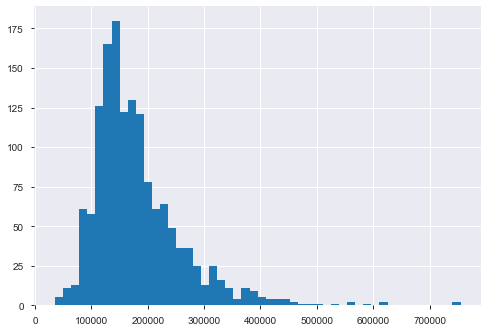

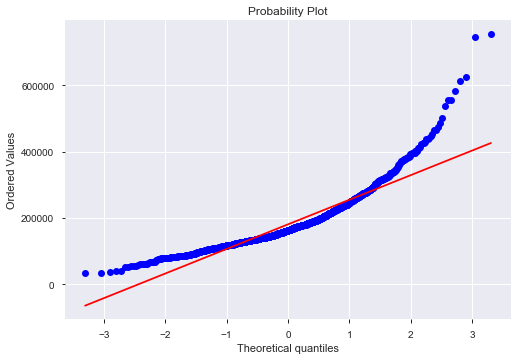

In [61]:
plt.hist(df_train.SalePrice,50)
fig = plt.figure()
ax = fig.add_subplot(111)
scipy.stats.probplot(df_train.SalePrice, sparams=(), dist='norm', fit=True, rvalue=False, plot=ax)
plt.show()


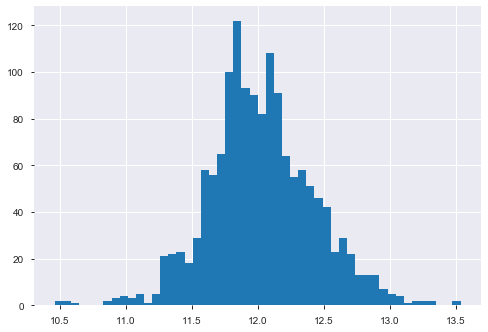

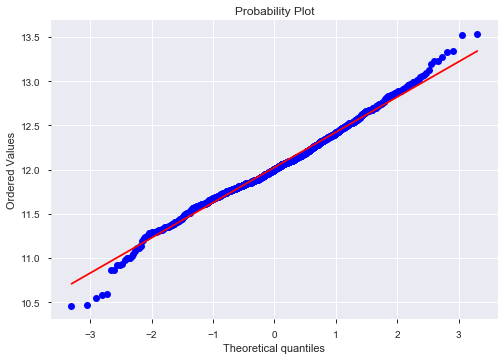

In [73]:
plt.hist(np.log(df_train.SalePrice),50)
fig = plt.figure()
ax = fig.add_subplot(111)
res = scipy.stats.probplot(np.log(df_train.SalePrice), sparams=(), dist='norm', fit=True, rvalue=False, plot=ax)
plt.show()


In [91]:
boxcox(df_train.SalePrice)


(array([7.93261046, 7.87826333, 7.95961804, ..., 8.02738182, 7.78100579,
        7.79588702]), -0.07692391328663316)

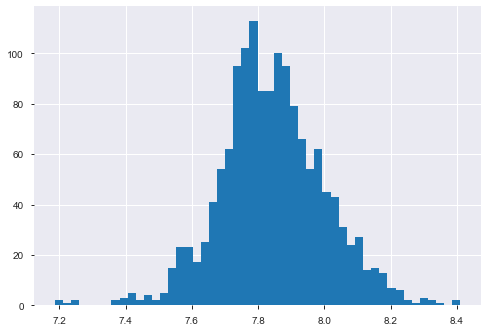

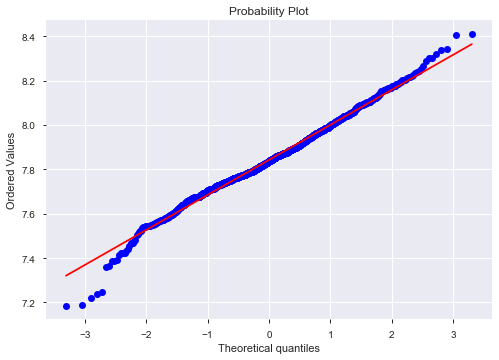

In [92]:
from scipy.stats import boxcox
plt.hist(boxcox(df_train.SalePrice)[0],50)
fig = plt.figure()
ax = fig.add_subplot(111)
res = scipy.stats.probplot(boxcox(df_train.SalePrice)[0], sparams=(), dist='norm', fit=True, rvalue=False, plot=ax)
plt.show()


In [85]:
sorted(np.log(df_train.SalePrice), reverse=True)




[13.534473028231162,
 13.521139497361697,
 13.345506928718539,
 13.323926946863102,
 13.275827535915461,
 13.229567991666638,
 13.226723392728571,
 13.195613839143922,
 13.1260306447518,
 13.091904169919621,
 13.071070083016778,
 13.053013299269535,
 13.049792684569493,
 13.021326833226556,
 13.008659261632127,
 12.994530005894443,
 12.991753427493052,
 12.988040814744458,
 12.971540487669746,
 12.962194625251508,
 12.959538518762063,
 12.955127458028414,
 12.936751613811438,
 12.929991484756872,
 12.92391243868049,
 12.90669184092882,
 12.906346868281233,
 12.904207367601158,
 12.88712700173598,
 12.886641043883259,
 12.885670953244288,
 12.885202034321916,
 12.8802918162046,
 12.8790171187726,
 12.864240107194092,
 12.86099861326992,
 12.86099861326992,
 12.858319703517948,
 12.850554654108839,
 12.84792653170257,
 12.84397135185964,
 12.841325847671216,
 12.841129801965447,
 12.834681304952548,
 12.832011076396668,
 12.827992316801751,
 12.827729194939907,
 12.823628446539173,
 12.8

In [63]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [86]:
np.log(df_train.SalePrice)


0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
5       11.870600
6       12.634603
7       12.206073
8       11.774520
9       11.678440
10      11.771436
11      12.751300
12      11.877569
13      12.540758
14      11.964001
15      11.790557
16      11.911702
17      11.407565
18      11.976659
19      11.842229
20      12.692503
21      11.845103
22      12.345835
23      11.774520
24      11.944708
25      12.454104
26      11.811547
27      12.631340
28      12.242887
29      11.134589
30      10.596635
31      11.914048
32      12.100156
33      12.016726
34      12.533576
35      12.641097
36      11.884489
37      11.938193
38      11.599103
39      11.314475
40      11.982929
41      12.043554
42      11.877569
43      11.777211
44      11.856515
45      12.675764
46      12.387085
47      12.428015
48      11.635143
49      11.751942
50      12.083905
51      11.648330
52      11.608236
53      12.860999
54      11.775290
55      12

In [64]:
pd.options.display.max_rows = 4000

df_train=df_train.astype({'MSSubClass': 'category'})
df_train=df_train.drop(axis=1,labels="Id")
print(df_train.dtypes)

MSSubClass       category
MSZoning           object
LotFrontage       float64
LotArea             int64
Street             object
Alley              object
LotShape           object
LandContour        object
Utilities          object
LotConfig          object
LandSlope          object
Neighborhood       object
Condition1         object
Condition2         object
BldgType           object
HouseStyle         object
OverallQual         int64
OverallCond         int64
YearBuilt           int64
YearRemodAdd        int64
RoofStyle          object
RoofMatl           object
Exterior1st        object
Exterior2nd        object
MasVnrType         object
MasVnrArea        float64
ExterQual          object
ExterCond          object
Foundation         object
BsmtQual           object
BsmtCond           object
BsmtExposure       object
BsmtFinType1       object
BsmtFinSF1          int64
BsmtFinType2       object
BsmtFinSF2          int64
BsmtUnfSF           int64
TotalBsmtSF         int64
Heating     

Preprocessing steps
1. categorize objects as categorical vars and run pd.get_dummies with dummy_na=True;
2. try binary encoding if gets too large
3. Check for na values in numerical vals and perhaps make a dummy var for these
4. Check if some numerical vals should be coded as categorical
5. Check if some columns as so correlated they could be eliminated.
6. Light analysis of predictive power of vars
7. Look at correlations between different vars?
8. check for nans in numerical vars

In [65]:
#List column_name, type, num of NA's
#Categorical NA's can be handled by a new dummy var at first cut. 
#Numerical NA's need an imputation value and then a new dummy NA var
df_type_na = pd.concat([df_train.dtypes,df_train.isna().sum()],axis=1)
print(df_type_na[0].value_counts())
print(df_type_na[((df_type_na[0]=="int64")|(df_type_na[0]=="float64"))&(df_type_na[1]>0)])
print(df_type_na[((df_type_na[0]=="object")|(df_type_na[0]=="category"))&(df_type_na[1]>0)])

object      43
int64       33
float64      3
category     1
Name: 0, dtype: int64
                   0    1
LotFrontage  float64  259
MasVnrArea   float64    8
GarageYrBlt  float64   81
                   0     1
Alley         object  1369
MasVnrType    object     8
BsmtQual      object    37
BsmtCond      object    37
BsmtExposure  object    38
BsmtFinType1  object    37
BsmtFinType2  object    38
Electrical    object     1
FireplaceQu   object   690
GarageType    object    81
GarageFinish  object    81
GarageQual    object    81
GarageCond    object    81
PoolQC        object  1453
Fence         object  1179
MiscFeature   object  1406


In [66]:
#Explore categorical variables
for column in df_train.columns:
    if df_train[column].dtype=="object":
        print(df_train[column].value_counts())
        


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype:

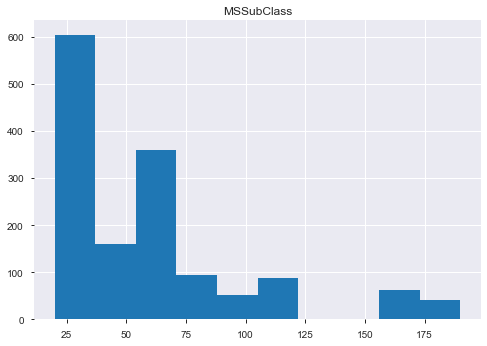

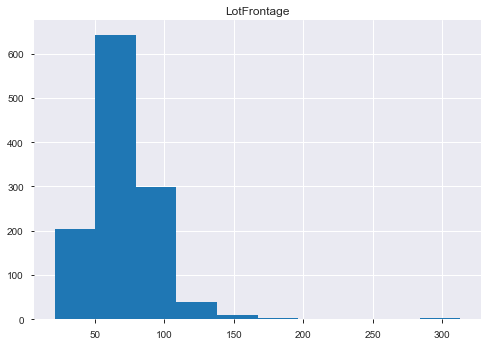

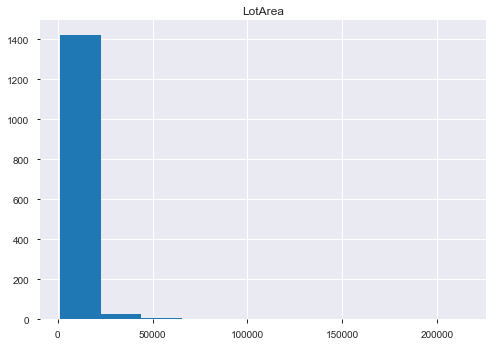

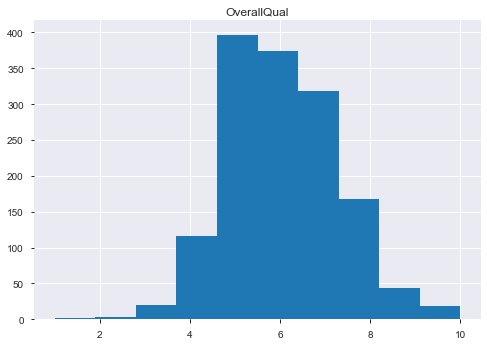

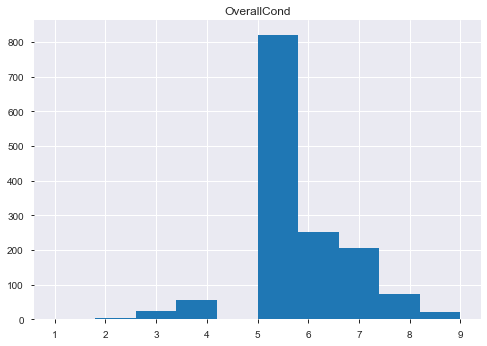

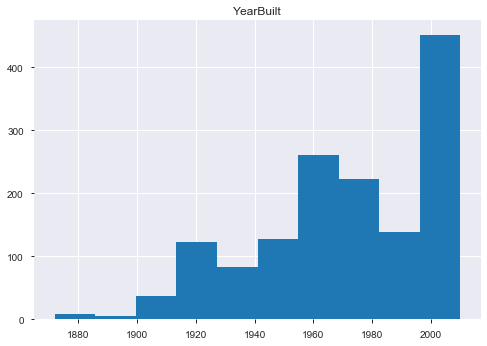

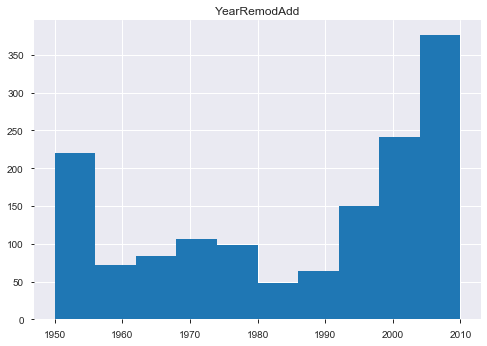

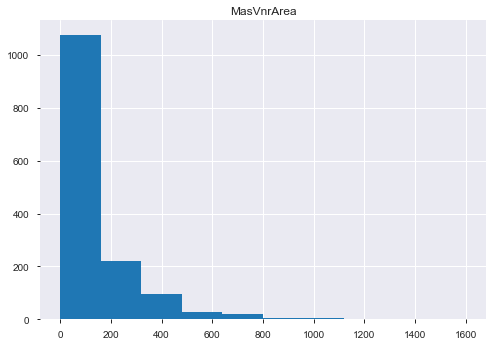

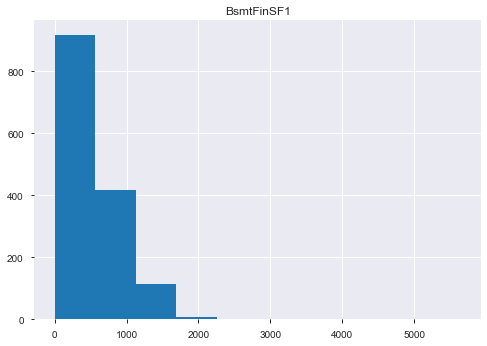

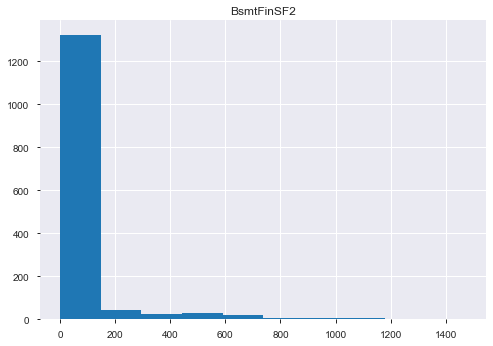

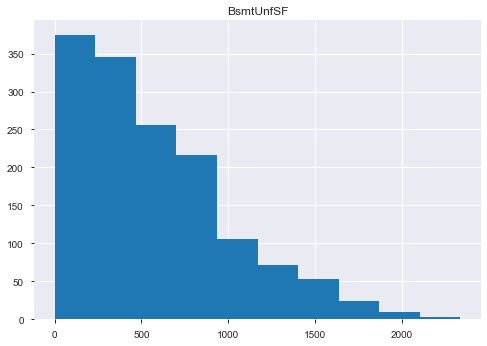

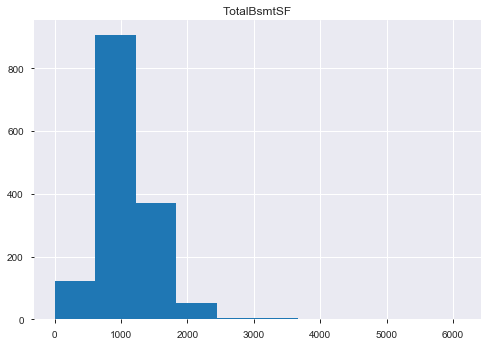

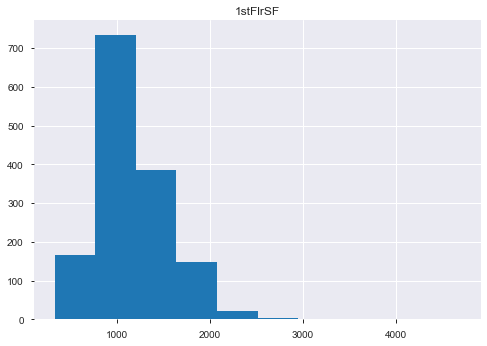

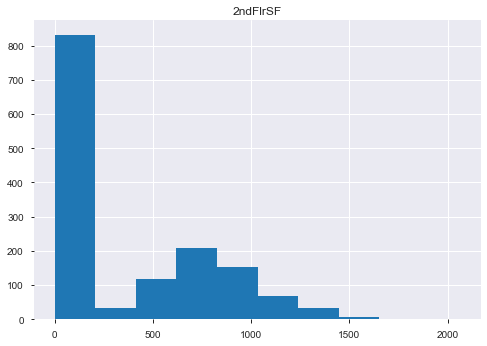

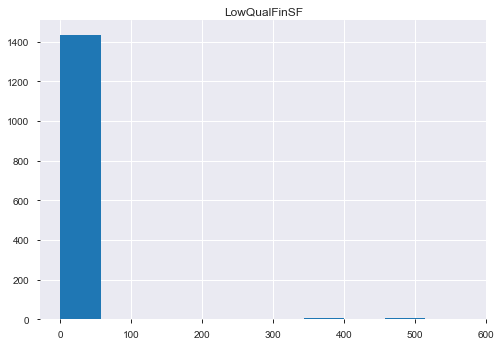

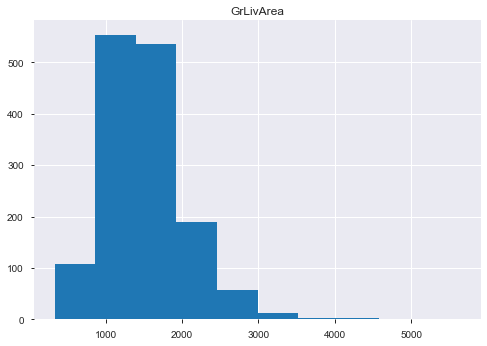

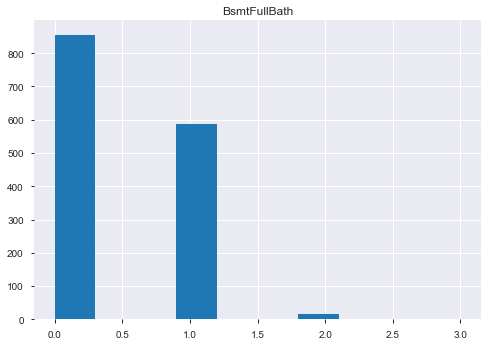

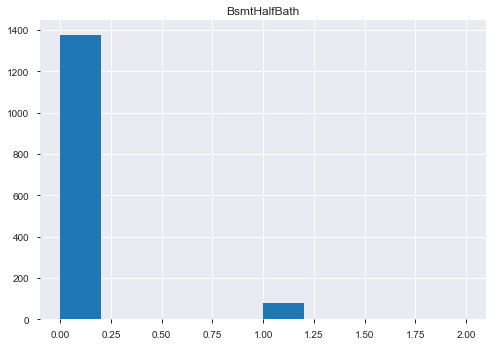

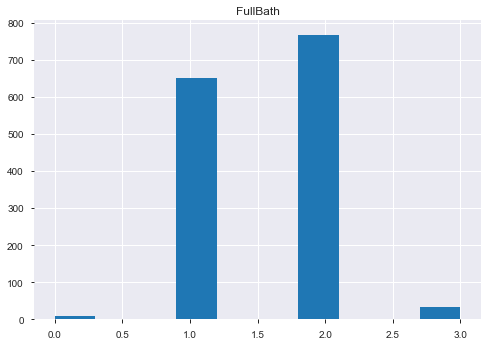

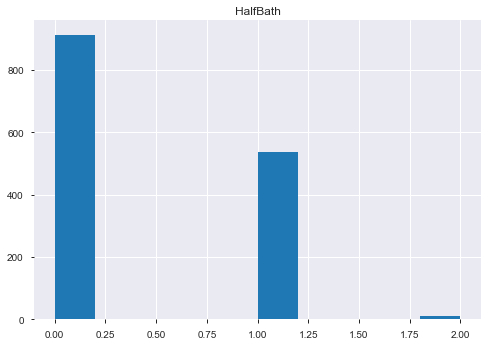

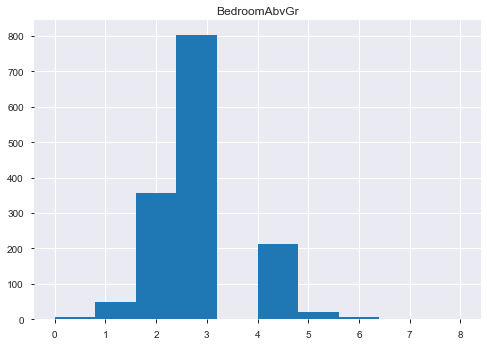

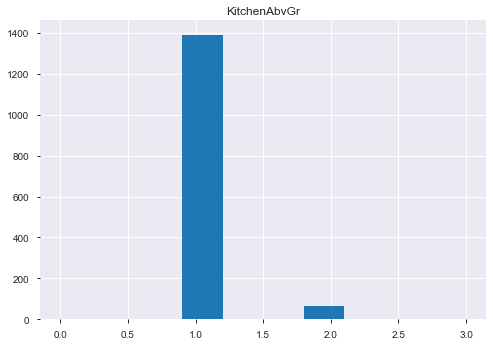

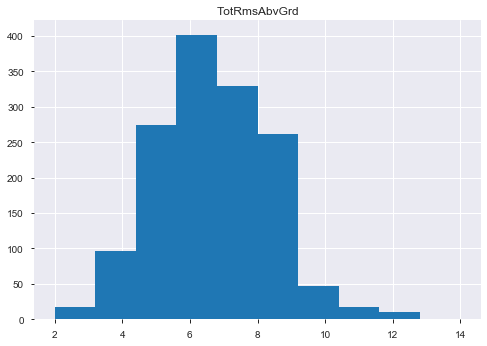

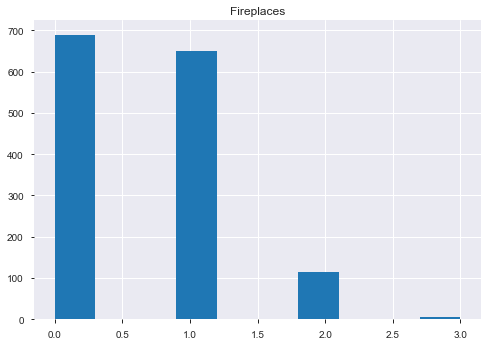

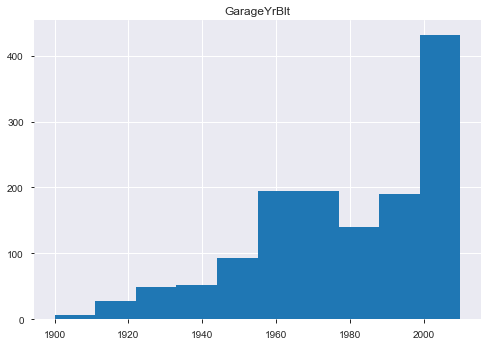

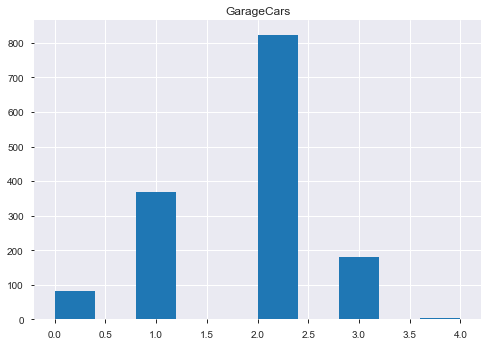

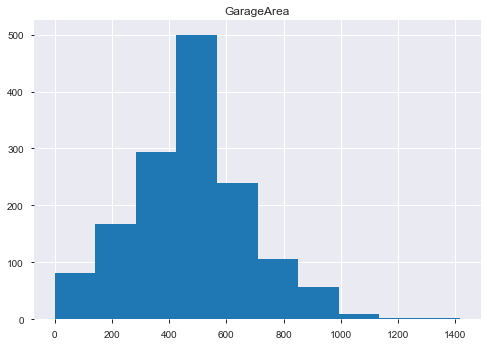

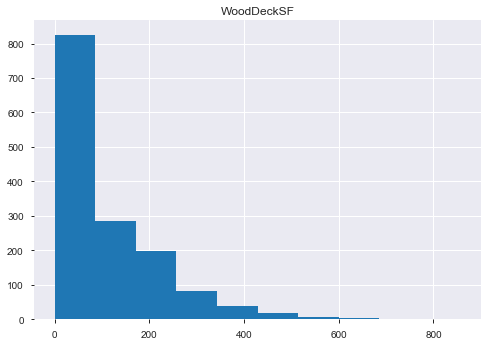

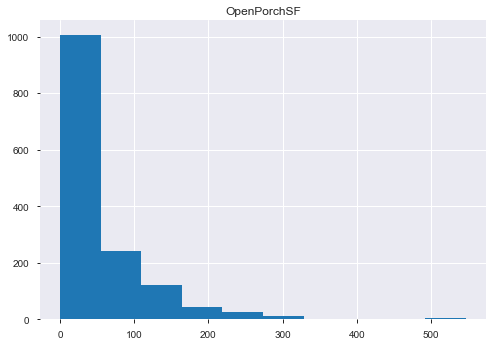

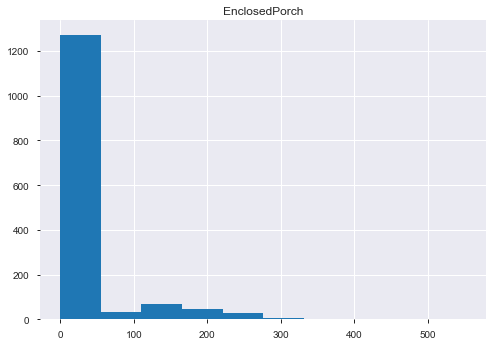

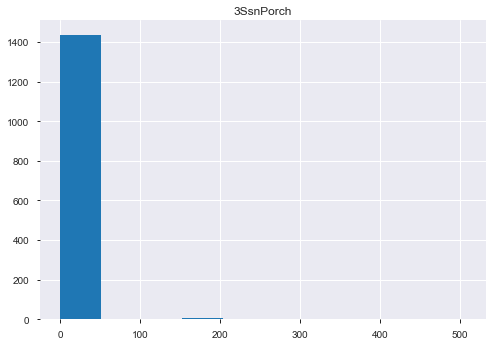

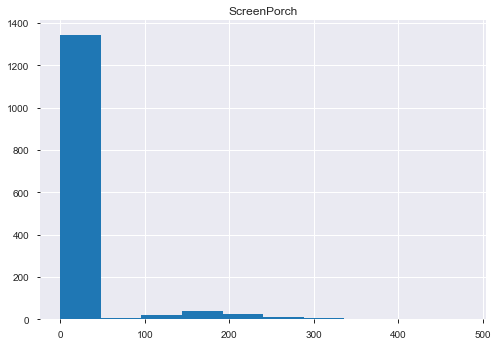

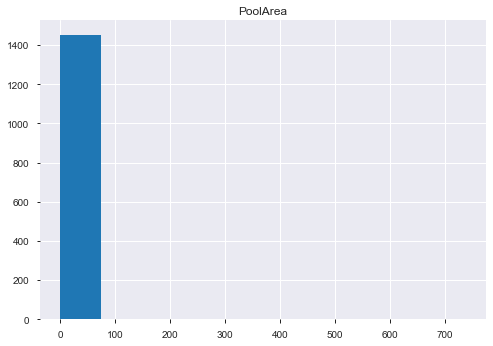

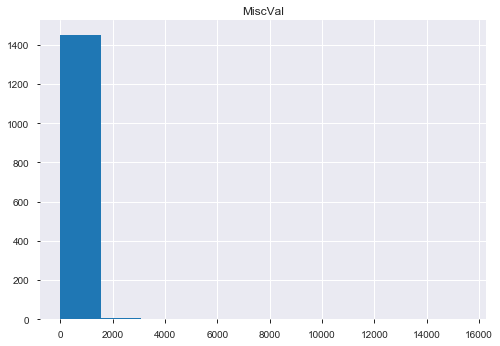

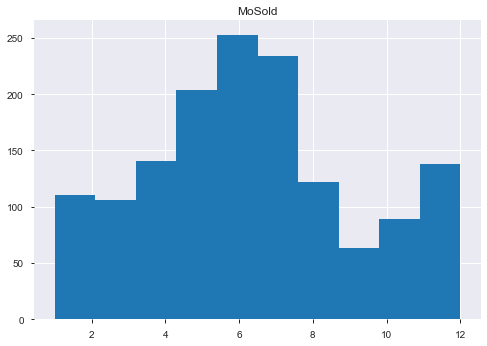

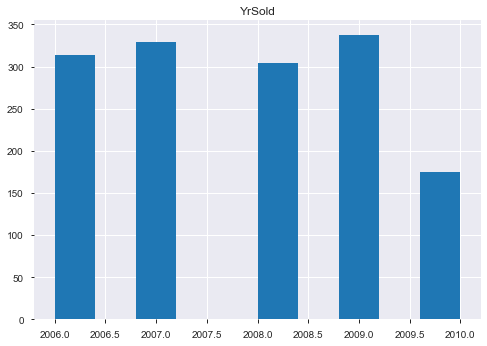

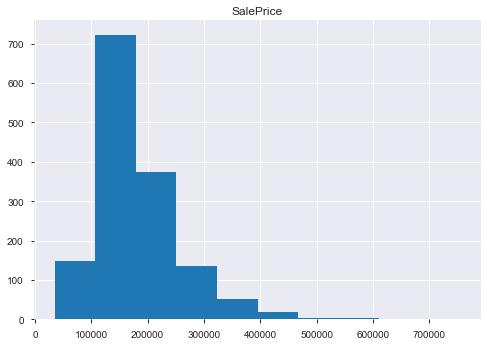

In [67]:
#Visualize numerical data
for column in df_train.columns:
    if df_train[column].dtype!="object":
        plt.figure()
        plt.hist(df_train[column])
        plt.title(column)
        plt.show()
        plt.close()

In [68]:
#Impute values for numerical NA values
df_train['LotFrontage_na']=df_train['LotFrontage'].isna().astype("int")
df_train.LotFrontage=df_train.LotFrontage.fillna(0)
df_train.MasVnrArea=df_train.MasVnrArea.fillna(0)
df_train.GarageYrBlt[df_train.GarageYrBlt.isna()]=df_train.YearRemodAdd[df_train.GarageYrBlt.isna()]

In [69]:
df_train

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0            60       RL         65.0     8450   Pave   NaN      Reg   
1            20       RL         80.0     9600   Pave   NaN      Reg   
2            60       RL         68.0    11250   Pave   NaN      IR1   
3            70       RL         60.0     9550   Pave   NaN      IR1   
4            60       RL         84.0    14260   Pave   NaN      IR1   
5            50       RL         85.0    14115   Pave   NaN      IR1   
6            20       RL         75.0    10084   Pave   NaN      Reg   
7            60       RL          0.0    10382   Pave   NaN      IR1   
8            50       RM         51.0     6120   Pave   NaN      Reg   
9           190       RL         50.0     7420   Pave   NaN      Reg   
10           20       RL         70.0    11200   Pave   NaN      Reg   
11           60       RL         85.0    11924   Pave   NaN      IR1   
12           20       RL          0.0    12968   Pave   NaN      IR2   
13           20       RL         91.0    10652   Pave   NaN      IR1   
14           20       RL          0.0    10920   Pave   NaN      IR1   
15           45       RM         51.0     6120   Pave   NaN      Reg   
16           20       RL          0.0    11241   Pave   NaN      IR1   
17           90       RL         72.0    10791   Pave   NaN      Reg   
18           20       RL         66.0    13695   Pave   NaN      Reg   
19           20       RL         70.0     7560   Pave   NaN      Reg   
20           60       RL        101.0    14215   Pave   NaN      IR1   
21           45       RM         57.0     7449   Pave  Grvl      Reg   
22           20       RL         75.0     9742   Pave   NaN      Reg   
23          120       RM         44.0     4224   Pave   NaN      Reg   
24           20       RL          0.0     8246   Pave   NaN      IR1   
25           20       RL        110.0    14230   Pave   NaN      Reg   
26           20       RL         60.0     7200   Pave   NaN      Reg   
27           20       RL         98.0    11478   Pave   NaN      Reg   
28           20       RL         47.0    16321   Pave   NaN      IR1   
29           30       RM         60.0     6324   Pave   NaN      IR1   
30           70  C (all)         50.0     8500   Pave  Pave      Reg   
31           20       RL          0.0     8544   Pave   NaN      IR1   
32           20       RL         85.0    11049   Pave   NaN      Reg   
33           20       RL         70.0    10552   Pave   NaN      IR1   
34          120       RL         60.0     7313   Pave   NaN      Reg   
35           60       RL        108.0    13418   Pave   NaN      Reg   
36           20       RL        112.0    10859   Pave   NaN      Reg   
37           20       RL         74.0     8532   Pave   NaN      Reg   
38           20       RL         68.0     7922   Pave   NaN      Reg   
39           90       RL         65.0     6040   Pave   NaN      Reg   
40           20       RL         84.0     8658   Pave   NaN      Reg   
41           20       RL        115.0    16905   Pave   NaN      Reg   
42           85       RL          0.0     9180   Pave   NaN      IR1   
43           20       RL          0.0     9200   Pave   NaN      IR1   
44           20       RL         70.0     7945   Pave   NaN      Reg   
45          120       RL         61.0     7658   Pave   NaN      Reg   
46           50       RL         48.0    12822   Pave   NaN      IR1   
47           20       FV         84.0    11096   Pave   NaN      Reg   
48          190       RM         33.0     4456   Pave   NaN      Reg   
49           20       RL         66.0     7742   Pave   NaN      Reg   
50           60       RL          0.0    13869   Pave   NaN      IR2   
51           50       RM         52.0     6240   Pave   NaN      Reg   
52           90       RM        110.0     8472   Grvl   NaN      IR2   
53           20       RL         68.0    50271   Pave   NaN      IR1   
54           80       RL         60.0     713

In [38]:
df_train.GarageYrBlt


0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
5       1993.0
6       2004.0
7       1973.0
8       1931.0
9       1939.0
10      1965.0
11      2005.0
12      1962.0
13      2006.0
14      1960.0
15      1991.0
16      1970.0
17      1967.0
18      2004.0
19      1958.0
20      2005.0
21      1930.0
22      2002.0
23      1976.0
24      1968.0
25      2007.0
26      2005.0
27      2008.0
28      1957.0
29      1920.0
30      1920.0
31      1966.0
32      2007.0
33      1959.0
34      2005.0
35      2004.0
36      1995.0
37      1954.0
38      1953.0
39      1955.0
40      1965.0
41      1959.0
42      1983.0
43      1977.0
44      1959.0
45      2005.0
46      2003.0
47      2006.0
48      2008.0
49      1966.0
50      1997.0
51      1985.0
52      1963.0
53      1981.0
54      1962.0
55      1964.0
56      1999.0
57      2004.0
58      2006.0
59      1973.0
60      2006.0
61      1935.0
62      2006.0
63      1990.0
64      1998.0
65      2004.0
66      19

In [70]:
df_explode=pd.get_dummies(df_train,dummy_na=True)
df_explode

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0            65.0     8450            7            5       2003          2003   
1            80.0     9600            6            8       1976          1976   
2            68.0    11250            7            5       2001          2002   
3            60.0     9550            7            5       1915          1970   
4            84.0    14260            8            5       2000          2000   
5            85.0    14115            5            5       1993          1995   
6            75.0    10084            8            5       2004          2005   
7             0.0    10382            7            6       1973          1973   
8            51.0     6120            7            5       1931          1950   
9            50.0     7420            5            6       1939          1950   
10           70.0    11200            5            5       1965          1965   
11           85.0    11924            9            5       2005          2006   
12            0.0    12968            5            6       1962          1962   
13           91.0    10652            7            5       2006          2007   
14            0.0    10920            6            5       1960          1960   
15           51.0     6120            7            8       1929          2001   
16            0.0    11241            6            7       1970          1970   
17           72.0    10791            4            5       1967          1967   
18           66.0    13695            5            5       2004          2004   
19           70.0     7560            5            6       1958          1965   
20          101.0    14215            8            5       2005          2006   
21           57.0     7449            7            7       1930          1950   
22           75.0     9742            8            5       2002          2002   
23           44.0     4224            5            7       1976          1976   
24            0.0     8246            5            8       1968          2001   
25          110.0    14230            8            5       2007          2007   
26           60.0     7200            5            7       1951          2000   
27           98.0    11478            8            5       2007          2008   
28           47.0    16321            5            6       1957          1997   
29           60.0     6324            4            6       1927          1950   
30           50.0     8500            4            4       1920          1950   
31            0.0     8544            5            6       1966          2006   
32           85.0    11049            8            5       2007          2007   
33           70.0    10552            5            5       1959          1959   
34           60.0     7313            9            5       2005          2005   
35          108.0    13418            8            5       2004          2005   
36          112.0    10859            5            5       1994          1995   
37           74.0     8532            5            6       1954          1990   
38           68.0     7922            5            7       1953          2007   
39           65.0     6040            4            5       1955          1955   
40           84.0     8658            6            5       1965          1965   
41          115.0    16905            5            6       1959          1959   
42            0.0     9180            5            7       1983          1983   
43            0.0     9200            5            6       1975          1980   
44           70.0     7945            5            6       1959          1959   
45           61.0     7658            9            5       2005          2005   
46           48.0    12822            7            5       2003          2003   
47           84.0    11096            8            5       2006          2006   
48           33.0     4456           

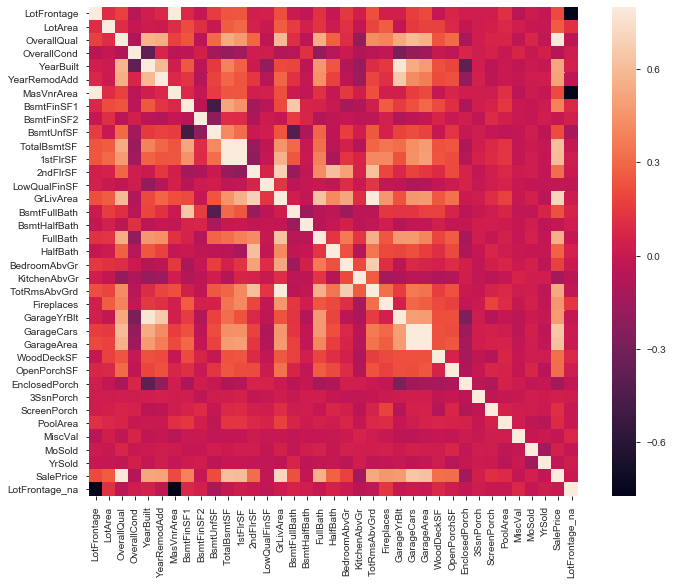

In [71]:
import seaborn as sns
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [97]:
df_train

In [65]:
r=pd.DataFrame([regr.feature_importances_.tolist(),list(X.columns)])
#sorted(r,reverse=True)
r=r.T

In [66]:
print(sum(r[0]))

r=r.sort_values(0,ascending=False)
r[2]=r[0].cumsum()
r

1.0000000000000004


0                      1         2
2       0.586818            OverallQual  0.586818
14      0.106415              GrLivArea  0.693232
10     0.0372984            TotalBsmtSF  0.730531
12     0.0285515               2ndFlrSF  0.759082
7      0.0284026             BsmtFinSF1  0.787485
11     0.0261598               1stFlrSF  0.813645
24     0.0223415             GarageCars  0.835986
25     0.0147805             GarageArea  0.850767
1      0.0128066                LotArea  0.863573
4     0.00896304              YearBuilt  0.872536
17      0.008065               FullBath  0.880601
5     0.00687593           YearRemodAdd  0.887477
21    0.00624408           TotRmsAbvGrd  0.893721
9     0.00557078              BsmtUnfSF  0.899292
6     0.00509005             MasVnrArea  0.904382
27    0.00479559            OpenPorchSF  0.909178
26    0.00439524             WoodDeckSF  0.913573
3     0.00415599            OverallCond  0.917729
33     0.0036565                 MoSold  0.921385
23    0.00335398            GarageYrBlt  0.924739
0     0.00324385            LotFrontage  0.927983
221   0.00244722            BsmtQual_Gd  0.930431
294   0.00239539      GarageType_Detchd  0.932826
22    0.00208962             Fireplaces  0.934916
219   0.00188909            BsmtQual_Ex  0.936805
19    0.00170164           BedroomAbvGr  0.938506
272   0.00167753         KitchenQual_Gd  0.940184
290   0.00165053      GarageType_Attchd  0.941834
169   0.00149935    Exterior1st_HdBoard  0.943334
230    0.0013616        BsmtExposure_Gd  0.944695
261   0.00135917           CentralAir_N  0.946054
34    0.00134828                 YrSold  0.947403
56    0.00133906            MSZoning_RM  0.948742
288   0.00133372        FireplaceQu_nan  0.950076
262   0.00131299           CentralAir_Y  0.951389
201   0.00130286           ExterQual_Ex  0.952691
18    0.00107667               HalfBath  0.953768
67    0.00102797           LotShape_Reg  0.954796
203   0.00102299           ExterQual_Gd  0.955819
41   0.000997917        MSSubClass_60.0  0.956817
102  0.000946302   Neighborhood_NoRidge  0.957763
69   0.000924482        LandContour_Bnk  0.958688
185  0.000900447    Exterior2nd_HdBoard  0.959588
273  0.000865851         KitchenQual_TA  0.960454
30   0.000865372            ScreenPorch  0.961319
232  0.000819554        BsmtExposure_No  0.962139
16   0.000797173           BsmtHalfBath  0.962936
192  0.000785711    Exterior2nd_VinylSd  0.963722
15   0.000783232           BsmtFullBath  0.964505
298  0.000748202       GarageFinish_Unf  0.965253
270  0.000717282         KitchenQual_Ex  0.965971
322  0.000715929            Fence_MnPrv  0.966686
236  0.000697798       BsmtFinType1_GLQ  0.967384
204  0.000677069           ExterQual_TA  0.968061
285  0.000668766         FireplaceQu_Gd   0.96873
8    0.000660143             BsmtFinSF2   0.96939
175  0.000656653    Exterior1st_VinylSd  0.970047
344  0.000655182   SaleCondition_Normal  0.970702
338  0.000636983            SaleType_WD  0.971339
199  0.000631912       MasVnrType_Stone  0.971971
28   0.000611918          EnclosedPorch  0.972583
93   0.000607278   Neighborhood_Crawfor   0.97319
20   0.000606977           KitchenAbvGr  0.973797
297   0.00053711       GarageFinish_RFn  0.974334
55   0.000526681            MSZoning_RL  0.974861
296  0.000511206       GarageFinish_Fin  0.975372
150  0.000489536          RoofStyle_Hip  0.975862
336  0.000461213           SaleType_New  0.976323
92   0.000448143   Neighborhood_CollgCr  0.976771
94    0.00043966   Neighborhood_Edwards  0.977211
63   0.000434043              Alley_nan  0.977645
77   0.000412393       LotConfig_Corner  0.978057
283  0.000398375         FireplaceQu_Ex  0.978456
78   0.000386575      LotConfig_CulDSac  0.978842
310  0.000380065          GarageCond_TA  0.979222
198  0.000379022        MasVnrType_None  0.979601
64   0.000370991           LotShape_IR1  0.979972
304  0.000369445          GarageQual_TA  0.980342
83    0.00035023          LandSlope_Gtl  0.980692
148  0.00034916

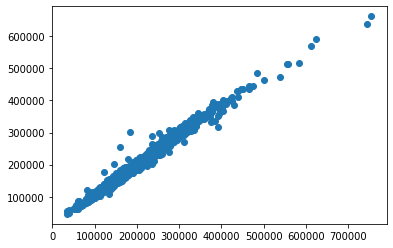

In [167]:
y_preds = regr.predict(X)
y_preds
plt.plot(y, y_preds,'o')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   4.,   8.,   4.,
          9.,  33.,  29.,  41.,  68.,  86., 160., 213., 235., 194., 108.,
         81.,  39.,  34.,  27.,  14.,  16.,  11.,   4.,   3.,   4.,   5.,
          1.,   2.,   2.,   1.,   2.,   5.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]), array([-117639.74  , -115391.8503, -113143.9606, -110896.0709,
        -108648.1812, -106400.2915, -104152.4018, -101904.5121,
         -99656.6224,  -97408.7327,  -95160.843 ,  -92912.9533,
         -90665.0636,  -88417.1739,  -86169.2842,  -83921.3945,
         -81673.5048,  -79425.6151,  -77177.7254,  -74929.8357,

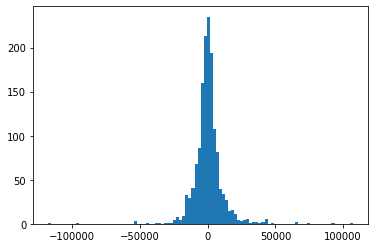

In [169]:
plt.hist(y-y_preds,100)

In [107]:


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
scaler = StandardScaler()
alpha_range=[.0001,.001, .005, .01]
for alpha in alpha_range:
    print(alpha)
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        scaler.fit(X_train)
        scaler.transform(X_test)
        lasso = Lasso(alpha=alpha, max_iter=3000)
        lasso.fit(scaler.transform(X_train), np.log(y_train))
        y_pred=lasso.predict(scaler.transform(X_test))
        print(np.sqrt(metrics.mean_squared_error(y_test,np.exp(y_pred))))

KFold(n_splits=5, random_state=None, shuffle=False)
0.0001
22001.059314597594
47950.188907636584
30214.944199388796
18853.96530227066
112782.07634047561
0.001
20441.877667061617
49163.41988669271
29406.04700816962
18292.719243266158
111202.71557837528
0.005
19366.597113637123
49786.66448740551
28601.896902608387
19480.29892653517
110925.72204015734
0.01
20662.473609158664
48430.44203162988
29692.384024145136
21277.389950784913
118712.28711521703


In [110]:
pd.DataFrame(zip(lasso.coef_,X.columns))

0                      1
0    0.000000            LotFrontage
1    0.015994                LotArea
2    0.094640            OverallQual
3    0.025495            OverallCond
4    0.035816              YearBuilt
5    0.029213           YearRemodAdd
6    0.000000             MasVnrArea
7    0.028611             BsmtFinSF1
8    0.000000             BsmtFinSF2
9   -0.000000              BsmtUnfSF
10   0.038977            TotalBsmtSF
11   0.000000               1stFlrSF
12   0.000000               2ndFlrSF
13  -0.000000           LowQualFinSF
14   0.122650              GrLivArea
15   0.005194           BsmtFullBath
16  -0.000000           BsmtHalfBath
17   0.003006               FullBath
18   0.000146               HalfBath
19   0.000000           BedroomAbvGr
20  -0.003552           KitchenAbvGr
21   0.000000           TotRmsAbvGrd
22   0.009579             Fireplaces
23   0.000000            GarageYrBlt
24   0.018663             GarageCars
25   0.029207             GarageArea
26   0.004272             WoodDeckSF
27   0.000000            OpenPorchSF
28   0.000000          EnclosedPorch
29   0.000000              3SsnPorch
30   0.007028            ScreenPorch
31  -0.000000               PoolArea
32  -0.000000                MiscVal
33  -0.000000                 MoSold
34  -0.000000                 YrSold
35   0.000000         LotFrontage_na
36   0.000000        MSSubClass_20.0
37  -0.003859        MSSubClass_30.0
38  -0.000000        MSSubClass_40.0
39  -0.000000        MSSubClass_45.0
40   0.000000        MSSubClass_50.0
41   0.000000        MSSubClass_60.0
42   0.000000        MSSubClass_70.0
43  -0.000000        MSSubClass_75.0
44   0.000000        MSSubClass_80.0
45   0.000000        MSSubClass_85.0
46  -0.000000        MSSubClass_90.0
47   0.000000       MSSubClass_120.0
48  -0.005891       MSSubClass_160.0
49  -0.000000       MSSubClass_180.0
50  -0.000000       MSSubClass_190.0
51   0.000000         MSSubClass_nan
52  -0.025724       MSZoning_C (all)
53   0.000000            MSZoning_FV
54  -0.000000            MSZoning_RH
55   0.000000            MSZoning_RL
56  -0.026238            MSZoning_RM
57   0.000000           MSZoning_nan
58  -0.000000            Street_Grvl
59   0.000000            Street_Pave
60   0.000000             Street_nan
61   0.000000             Alley_Grvl
62   0.000000             Alley_Pave
63  -0.000000              Alley_nan
64   0.000000           LotShape_IR1
65   0.000000           LotShape_IR2
66  -0.000000           LotShape_IR3
67  -0.000000           LotShape_Reg
68   0.000000           LotShape_nan
69  -0.000000        LandContour_Bnk
70   0.000000        LandContour_HLS
71   0.000000        LandContour_Low
72  -0.000000        LandContour_Lvl
73   0.000000        LandContour_nan
74   0.000000       Utilities_AllPub
75  -0.000000       Utilities_NoSeWa
76   0.000000          Utilities_nan
77   0.000000       LotConfig_Corner
78   0.000064      LotConfig_CulDSac
79  -0.000000          LotConfig_FR2
80   0.000000          LotConfig_FR3
81  -0.000000       LotConfig_Inside
82   0.000000          LotConfig_nan
83  -0.000000          LandSlope_Gtl
84   0.000075          LandSlope_Mod
85  -0.000000          LandSlope_Sev
86   0.000000          LandSlope_nan
87  -0.000000   Neighborhood_Blmngtn
88  -0.000000   Neighborhood_Blueste
89  -0.000000    Neighborhood_BrDale
90   0.000000   Neighborhood_BrkSide
91   0.000000   Neighborhood_ClearCr
92   0.000000   Neighborhood_CollgCr
93   0.008677   Neighborhood_Crawfor
94  -0.004982   Neighborhood_Edwards
95   0.000000   Neighborhood_Gilbert
96  -0.000000    Neighborhood_IDOTRR
97  -0.002347   Neighborhood_MeadowV
98  -0.000000   Neighborhood_Mitchel
99  -0.000000     Neighborhood_NAmes
100 -0.000000   Neighborhood_NPkVill
101 -0.000000    Neighborhood_NWAmes
102  0.000000   Neighborhood_NoRidge
103  0.004218   Neighborhood_NridgHt
104 -0.000000   Neighborhood_OldTown
105 -0.000000     Neighborhood_SWISU
106 -0.000000    Neighborhood_Sawyer
107 -0.000000   

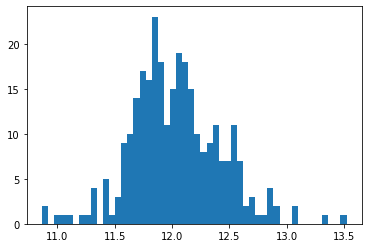

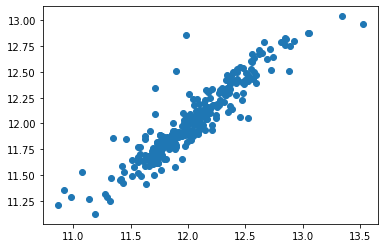

In [94]:
plt.hist(np.log(y_test),50)
plt.figure()
plt.plot(np.log(y_test),y_pred,'o')

In [83]:
scaler.fit(X_train)
scaler.transform(X_train)

array([[ 0.21656877, -0.19407633,  0.65264239, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       [ 0.65618004, -0.08633823, -0.07334457, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       [ 0.30449102,  0.06824252,  0.65264239, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       ...,
       [ 0.62687262, -0.09186566,  0.65264239, ..., -2.09343939,
         3.23279761,  0.        ],
       [ 0.18726135, -0.00436359,  1.37862936, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       [ 0.01141685,  0.03095577, -0.07334457, ...,  0.47768281,
        -0.3093296 ,  0.        ]])

In [57]:


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
scaler = StandardScaler()
for max_depth in range(2,20,2):
    print(max_depth)
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        scaler.fit(X_train)
        scaler.transform(X_test)
        regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
        regr.fit(scaler.transform(X_train), np.log(y_train))
        y_pred=regr.predict(scaler.transform(X_test))
        print(np.sqrt(metrics.mean_squared_error(y_test),np.exp(y_pred)))

NameError: name 'X' is not defined